# CPPN Experiments

Compositional pattern-producing networks (CPPNs) are neural networks that map positions to outputs. When sampled across 2D or 3D spaces they can produce pixel or voxel patterns.

The goal of this notebook is:
1. Evalautate my CPPN implementation on two 2D pattern types across multiple scales. One pattern is random and the other is repeating and ordered.
2. Then compare these results to an idea for recurrent CPPNs.

This was partly inspired by my past experiments with CPPNs and also by reading Lipson’s Unshackling Evolution paper where a direct and indirect (CPPN) method was used. The direct encoding is criticized for “lack of regularity and organization.” However, my suspicion was that both genotype methods had phenotype space biases and that perhaps CPPN’s bias may be more conducive to good robots. In the next notebook I evaluate a direct approach. In addition to the phenotype bias, I also wanted to explore CPPN with modularity.

## #1 - CPPN evolution and scale

In [512]:
# ipython magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Python neat library
from neat.config import Config 
from neat import nn

# Source
from src import patterns, cppn
from src.plot import plot_fitnesses, plot_patterns, plot_best

# GA params
num_gens = 100
config = Config('config.txt')
config.report = False
config.pop_size = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Three grid dimensions are evaluated and averaged over multiple runs. The random target is generated once.

In [ ]:
# GA metaparams
num_repeats = 5
dimensions = [16, 32, 64]
targets = [[patterns.random(d, d), patterns.checkerboard(d, d, block_size=4)] for d in dimensions]

### View the objectives

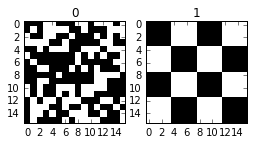

In [411]:
# The 16x16 pattern
plot_patterns(*targets[0])

### Evaluate the CPPN for each target and for each dimension

In [ ]:
# Store the best fitness and output from each run.
cppn_fitnesses = np.zeros((len(dimensions), 2, num_repeats, num_gens))
cppn_output = np.zeros((len(dimensions), 2, num_repeats), dtype=object)

for di in range(len(dimensions)):
    for ti, target in enumerate(targets[di]):
        for ri in range(num_repeats):
            stats, best_output = cppn.evolve_cppn(config, target, num_gens)
            cppn_fitnesses[di, ti, ri, :] = [c.fitness for c in stats.most_fit_genomes]
            cppn_output[di, ti, r=i] = best_output

### Evalaution

The fitness function I chose to use was a balanced-accuracy-score with each position considered one guess. This score is the average of correct positives over all positives and correct negatives over true negatives. Both classes therefore have equal weight despite their abundance. This is not important for these examples since the pos/neg ratio ~.5 but is very important for patterns I was tryign earlier and others that have highly imbalanced ratios. For example, if a pattern consists of a single, mall empty circle, returning positive everywhere will get a very high score. Conceptually that dot is worth a lot even if a small percentage of area. Thus, a function doing nothing will always get a score of 0.5.

## Plot evolution curves

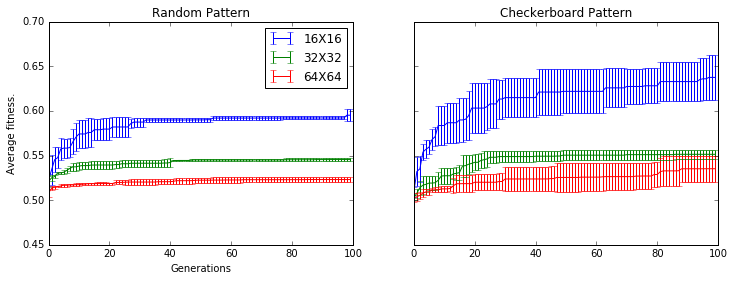

In [251]:
plot_fitnesses(cppn_fitnesses, dimensions, 'Standard CPPN')

Best Random Fitness: 0.608088235294
Best Grid Fitness: 0.671875


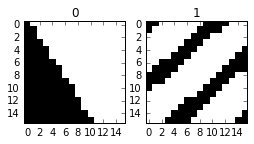

In [516]:
# Print best 16x16 targets
plot_best(cppn_fitnesses, cppn_outputs)

Best Random Fitness: 0.548150778017
Best Grid Fitness: 0.55859375


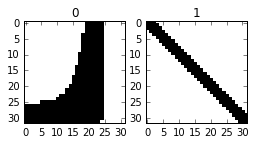

In [518]:
# Best 32 x 32 target
plot_best(cppn_fitnesses, cppn_outputs, i=1)

### CPPN thoughts and takeaways

1. While I had concieved of this as a challenge of scale but for CPPN it is really one of resolutions. The better test would have been to take the random pattern and double the grid size without changing the pattern.
2. These stripes appear to be an early local minumum in the complexification process that the CPPN did not seem able to get out of. Theroretically the checkerboard should be a reasonable target as a function such as cos(x)*cos(y) produces the right pattern type.
3. The results are clearly poor. There may be a fault in my implementation but it may aso be a function of population size and generations (only 16x16 checker did not plateau yet). It does not appear to have the resolution of individual pixels and so the random taret is a bit hopeless. It jsut picks an arbitrary segment that is more right than wrong.

## #2  Recurrent CPPN

In this model, the CPPN is evaluated across the space a fixed number of times. There are seven inputs: x, y, current value and four adjacent neighbors values.

My motivation for this was:
1. Was partially influenced by Conways Game of Life where complex shapes and patterns emerge from very simple rules.
2. I had been thinking about modularity in CPPN and other genetic representations. In solutions with regularity, one wants to repeat a motif with local variation. I considered one method where there would be a 'root CPPN' which would have one output for each child CPPN, this activates the 'module CPPN' with the calling position as the frame of reference. The parent could also have outputs for scale and rotation that allow local variation of the module pattern. Tthat seemed a bit over engineered to start with and I chose to first test the recurrent component. I.e having a CPPN iteratively queried.

In [ ]:
import copy
num_steps = [4, 8, 16]

recurrent_config = copy.deepcopy(config)
recurrent_config.input_nodes = 7
recurrent_config.hidden_nodes = 0
initial_connection = 'fully_connected'

recurr_fitnesses = np.zeros((len(num_steps), 2, num_repeats, num_gens))
recurr_outputs = np.zeros((len(num_steps), 2, num_repeats), dtype=object)
recurr_genomes = np.zeros((len(num_steps), 2, num_repeats), dtype=object)

for si, s in enumerate(num_steps):
    for ti, target in enumerate(w[0]):
        for ri in range(num_repeats):
            print(si, ti, ri)
            stats, best_output = cppn.evolve_recurrent_cppn(recurrent_config, target, s, num_gens)
            recurr_fitnesses[si, ti, ri, :] = [c.fitness for c in stats.most_fit_genomes]
            recurr_outputs[si, ti, ri] = best_output
            recurr_genomes[si, ti, ri] = stats.best_genome()

## Evolution Results

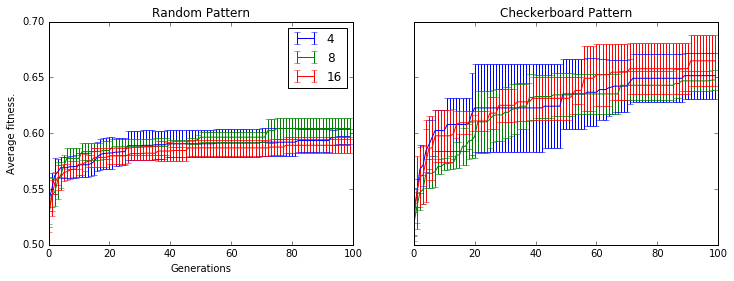

In [426]:
plot_fitnesses(recurr_fitnesses, num_steps, 'Recurrent CPPN')

TODO: make the std curve a shaded area to help see overlap

## Print best 4-step results

Best Random Fitness: 0.609692451072
Best Grid Fitness: 0.68359375


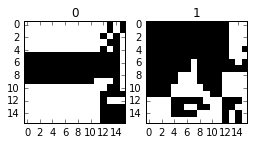

In [513]:
plot_best(recurr_fitnesses, recurr_outputs, i=0)

## Print best 8-step results

Best Random Fitness: 0.622211867039
Best Grid Fitness: 0.66015625


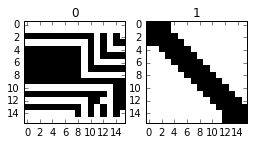

In [514]:
plot_best(recurr_fitnesses, recurr_outputs, i=1)

## Print best 16-step results

Best Random Fitness: 0.596738117428
Best Grid Fitness: 0.703125


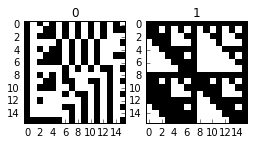

In [515]:
plot_best(recurr_fitnesses, recurr_outputs, i=2)

# Display growth steps

Interesting patterns! Let's now take a peek at what is going on.

In [436]:
def plot_growth_steps(i, t):
    genome = recurr_genomes[i, t, np.argmax(recurr_fitnesses[i, t].max(axis=1))]
    net = nn.create_feed_forward_phenotype(genome)
    steps = list(cppn.express_recurrent_cppn(net, 16, 16, num_steps[i], return_steps=True))
    plot_patterns(*steps)

## best 4 steps growth

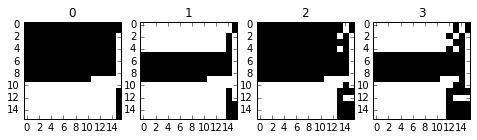

In [437]:
# Random target
plot_growth_steps(0, 0)

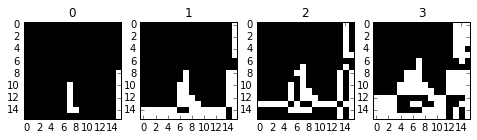

In [438]:
# Checkerboard target
plot_growth_steps(0, 1)

## best 8 steps growth

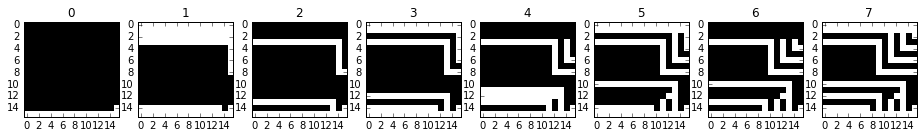

In [439]:
# Random
plot_growth_steps(1, 0)

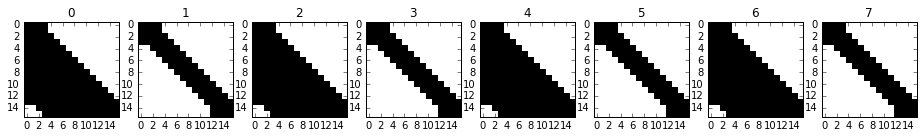

In [450]:
# Checkerboard
plot_growth_steps(1, 1)

An oscillating pattern!

## 16 Steps

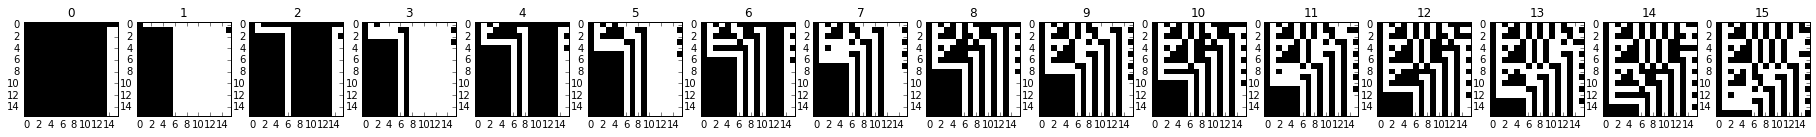

In [441]:
# Random
plot_growth_steps(2, 0)

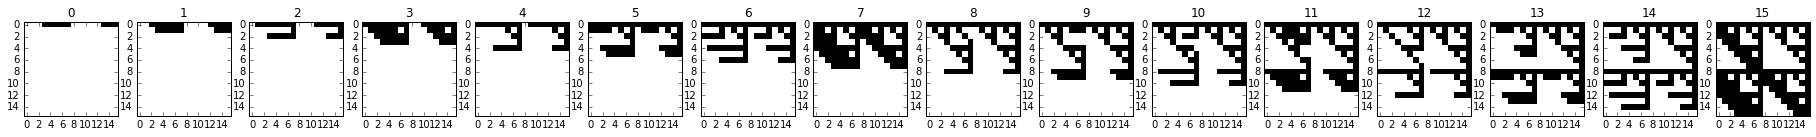

In [442]:
# Grid
plot_growth_steps(2, 1)

Cool!!! A fractal growth pattern :0 

## Lets view the 16 step grid next to target

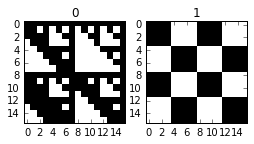

In [448]:
best_grid = recurr_outputs[2, 1, np.argmax(recurr_fitnesses[2, 1].max(axis=1))]
plot_patterns(best_grid, targets[0][1])

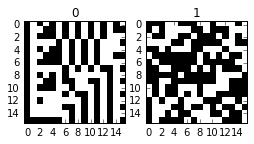

In [497]:
best_grid = recurr_outputs[2, 0, np.argmax(recurr_fitnesses[2, 0].max(axis=1))]
plot_patterns(best_grid, targets[0][0])

# Results Overview

In [494]:
print('Best Results:')
print('\tRandom Target')
print('\t\tCPPN:', cppn_fitnesses[0, 0, : -1].max())
for i, steps in enumerate(num_steps):
    print(('\t\tRecurrent (%d steps):' % (steps)), recurr_fitnesses[i, 0, :, -1].max())

print('\tCheckerboard Target')
print('\t\tCPPN:', cppn_fitnesses[0, 1, : -1].max())
for i, steps in enumerate(num_steps):
    print(('\t\tRecurrent (%d steps):' % (steps)), recurr_fitnesses[i, 1, :, -1].max())


Best Results:
	Random Target
		CPPN: 0.608088235294
		Recurrent (4 steps): 0.609692451072
		Recurrent (8 steps): 0.622211867039
		Recurrent (16 steps): 0.596738117428
	Checkerboard Target
		CPPN: 0.671875
		Recurrent (4 steps): 0.68359375
		Recurrent (8 steps): 0.66015625
		Recurrent (16 steps): 0.703125


## Concluding Thoughts

* Recurrent-CPPNS performed better than expected and better than CPPN
* The patterns produced by REC-CPPN would not have been expected by CPPN
* Recurrent-CPPNS is a bad name since people will expect a CPPN using a recurrent network :( 
* CPPN use of arbitrary math functions make it make it suited for images but not arbitrary problems such as soft robots.
* REC-CPPN seem able to explore a greater space but still biased by possible patterns.
* The increase in REC-CPPN steps let to increasingly complex patterns. 
* The balanced-accuracy-score function worked well for the evolution but maps large improvements to small numerical changes making it hard to see from the numbers how much better a change is (.67 to .7 can be huge).
* In hindsight, removing the hidden nodes from REC-CPPN may produce a lot of bias, I did this so the network size would be roughly the same since REC-CPPN has 5 more inputs. Regardless, some config may do better for soem network sizes than others making a direct comparison somewhat flawed.


**Further Work:**
* Find better name
* Work on ways to remove having to arbitrarily deciding a step size. Evaluating the solution at every step may be practically impossible and lower the significicance of the result due to the multiple testing issue. The simulation could run until convergence which may not always happen. 
* Explore correlation between scale, step-size and fitness with REC-CPPN